# Data Acquisition and Preprocessing

Download, clean, and prepare market data for RL trading environment

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator
import warnings
warnings.filterwarnings('ignore')

print(f"pandas {pd.__version__}, yfinance {yf.__version__}, numpy {np.__version__}")

pandas 2.3.3, yfinance 1.1.0, numpy 2.2.6


In [ ]:
# Define Universe and Parameters
tickers = {
    'SPY': 'S&P 500 Benchmark',
    'AAPL': 'Technology (Growth)',
    'MSFT': 'Technology (Stable)', 
    'JPM': 'Financials',
    'XOM': 'Energy',
    'JNJ': 'Healthcare'
}

start_date = '2015-01-01'
end_date = '2024-01-01'

print("Selected Universe:")
for ticker, desc in tickers.items():
    print(f"  {ticker}: {desc}")
print(f"\nDate range: {start_date} to {end_date}")

Selected Universe:
  SPY: S&P 500 Benchmark
  AAPL: Technology (Growth)
  MSFT: Technology (Stable)
  JPM: Financials
  XOM: Energy
  JNJ: Healthcare

Date range: 2015-01-01 to 2024-01-01


In [ ]:
# Test Download (Single Asset)
spy_test = yf.download('SPY', start='2023-01-01', end='2023-02-01', progress=False)
print(f"Shape: {spy_test.shape}")
print(f"Columns: {spy_test.columns.tolist()}")
print(f"Index type: {type(spy_test.index).__name__}")

Shape: (20, 5)
Columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
Index type: DatetimeIndex


In [ ]:
# Column Flattener (for MultiIndex from yfinance)
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    return df

spy_test = flatten_columns(spy_test)
print(f"After flattening: {spy_test.columns.tolist()}")

After flattening: ['Close', 'High', 'Low', 'Open', 'Volume']


In [ ]:
# Download Full Universe
raw_data = {}
for ticker in tickers.keys():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    raw_data[ticker] = flatten_columns(df)
    print(f"{ticker}: {df.shape}")

print(f"\nDownloaded {len(raw_data)} assets successfully")

SPY: (2264, 5)


AAPL: (2264, 5)


MSFT: (2264, 5)


JPM: (2264, 5)


XOM: (2264, 5)


JNJ: (2264, 5)

Downloaded 6 assets successfully


In [ ]:
# Alignment Check
spy_dates = set(raw_data['SPY'].index)
print(f"SPY trading days: {len(spy_dates)}\n")

for ticker, df in raw_data.items():
    ticker_dates = set(df.index)
    missing = len(spy_dates - ticker_dates)
    extra = len(ticker_dates - spy_dates)
    print(f"{ticker}: {len(ticker_dates)} days (missing: {missing}, extra: {extra})")

SPY trading days: 2264

SPY: 2264 days (missing: 0, extra: 0)
AAPL: 2264 days (missing: 0, extra: 0)
MSFT: 2264 days (missing: 0, extra: 0)
JPM: 2264 days (missing: 0, extra: 0)
XOM: 2264 days (missing: 0, extra: 0)
JNJ: 2264 days (missing: 0, extra: 0)


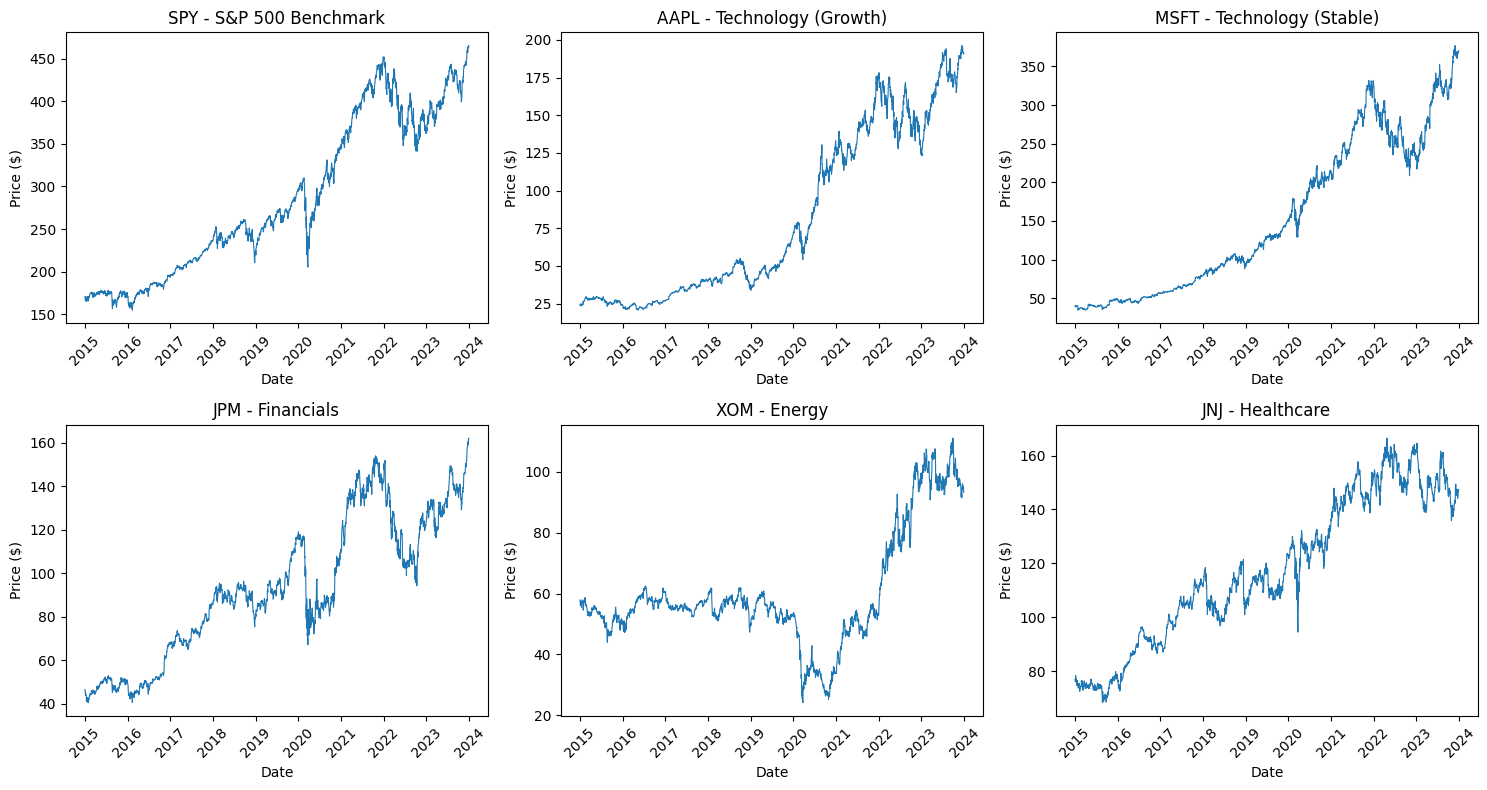

In [ ]:
# Visualize Raw Price Data
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (ticker, df) in enumerate(raw_data.items()):
    ax = axes[idx]
    ax.plot(df.index, df['Close'], linewidth=0.8)
    ax.set_title(f"{ticker} - {tickers[ticker]}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('price_history.png', dpi=100)
plt.show()

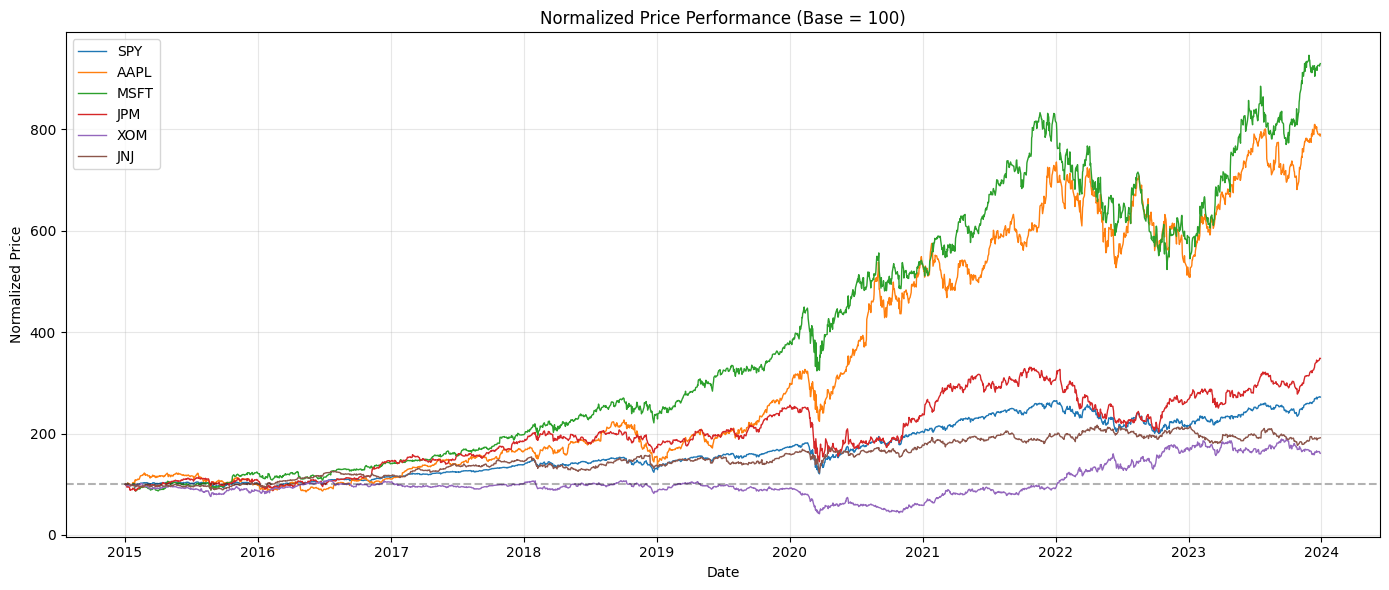

In [ ]:
#  Normalized Price Comparison (Base 100)
fig, ax = plt.subplots(figsize=(14, 6))

for ticker, df in raw_data.items():
    normalized = (df['Close'] / df['Close'].iloc[0]) * 100
    ax.plot(df.index, normalized, label=ticker, linewidth=1)

ax.axhline(y=100, color='black', linestyle='--', alpha=0.3)
ax.set_title('Normalized Price Performance (Base = 100)')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('normalized_performance.png', dpi=100)
plt.show()

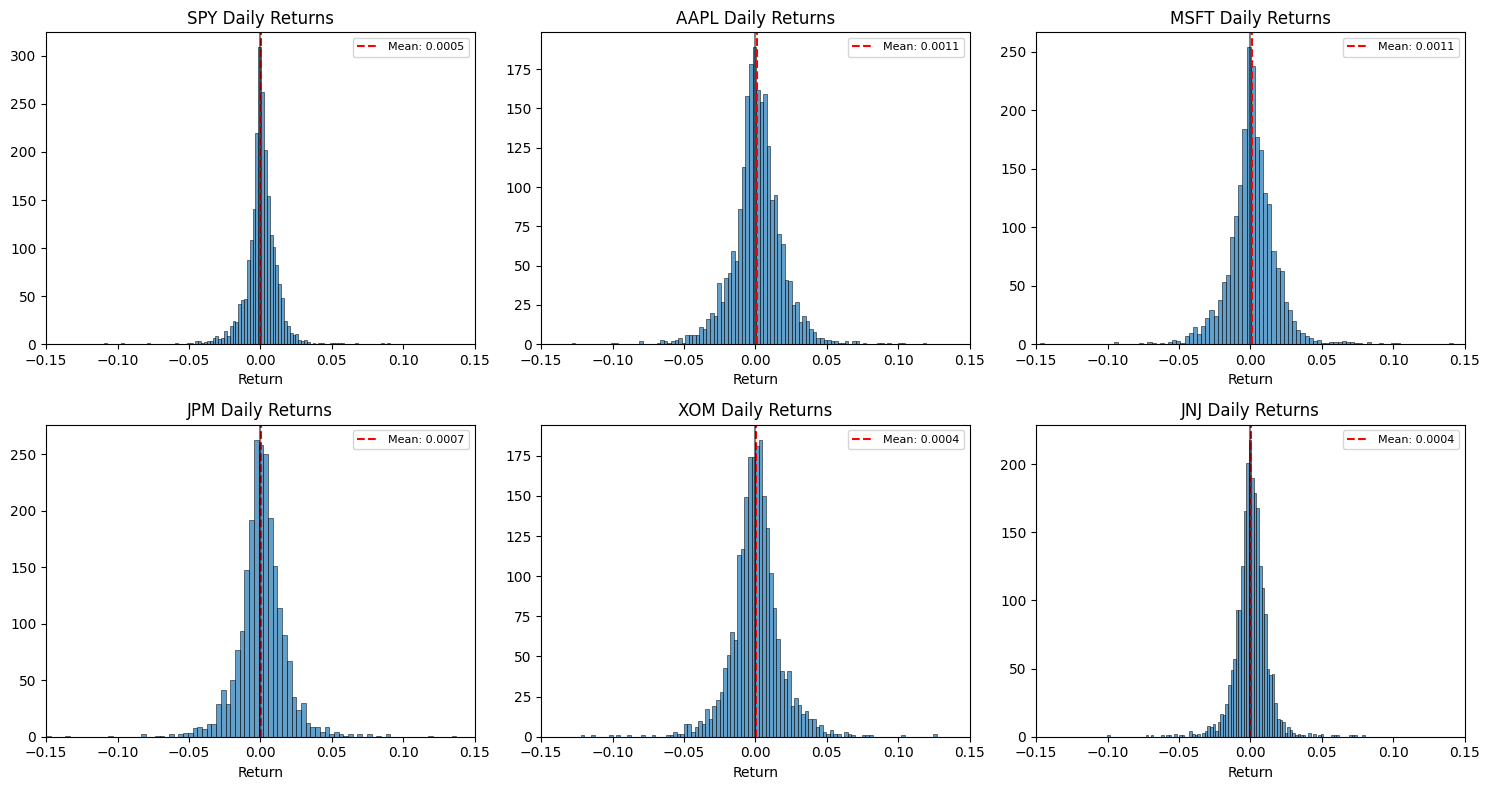

In [ ]:
# Daily Returns Distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (ticker, df) in enumerate(raw_data.items()):
    returns = df['Close'].pct_change().dropna()
    ax = axes[idx]
    ax.hist(returns, bins=100, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.4f}')
    ax.axvline(0, color='black', linestyle='-', alpha=0.5)
    ax.set_title(f"{ticker} Daily Returns")
    ax.set_xlabel('Return')
    ax.legend(fontsize=8)
    ax.set_xlim(-0.15, 0.15)

plt.tight_layout()
plt.savefig('returns_distribution.png', dpi=100)
plt.show()

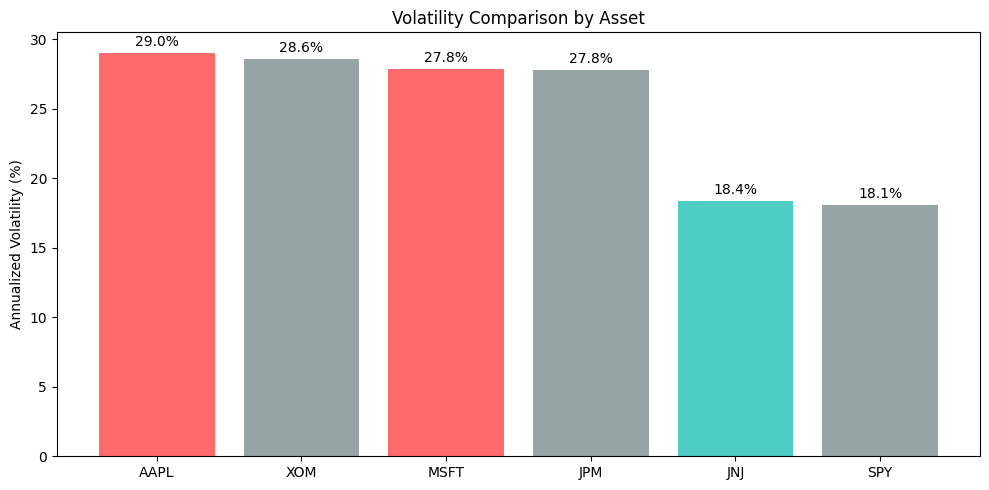


Hypothesis Check: Tech (AAPL/MSFT) vs Healthcare (JNJ)
Ticker  Annualized Volatility
  AAPL               0.290385
   XOM               0.285844
  MSFT               0.278259
   JPM               0.277694
   JNJ               0.183514
   SPY               0.180955


In [ ]:
# Volatility Comparison
volatility_data = []
for ticker, df in raw_data.items():
    returns = df['Close'].pct_change().dropna()
    vol = returns.std() * np.sqrt(252)  # Annualized
    volatility_data.append({'Ticker': ticker, 'Annualized Volatility': vol})

vol_df = pd.DataFrame(volatility_data).sort_values('Annualized Volatility', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#ff6b6b' if t in ['AAPL', 'MSFT'] else '#4ecdc4' if t == 'JNJ' else '#95a5a6' 
          for t in vol_df['Ticker']]
bars = ax.bar(vol_df['Ticker'], vol_df['Annualized Volatility'] * 100, color=colors)
ax.set_ylabel('Annualized Volatility (%)')
ax.set_title('Volatility Comparison by Asset')

for bar, vol in zip(bars, vol_df['Annualized Volatility']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{vol*100:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('volatility_comparison.png', dpi=100)
plt.show()

print("\nHypothesis Check: Tech (AAPL/MSFT) vs Healthcare (JNJ)")
print(vol_df.to_string(index=False))

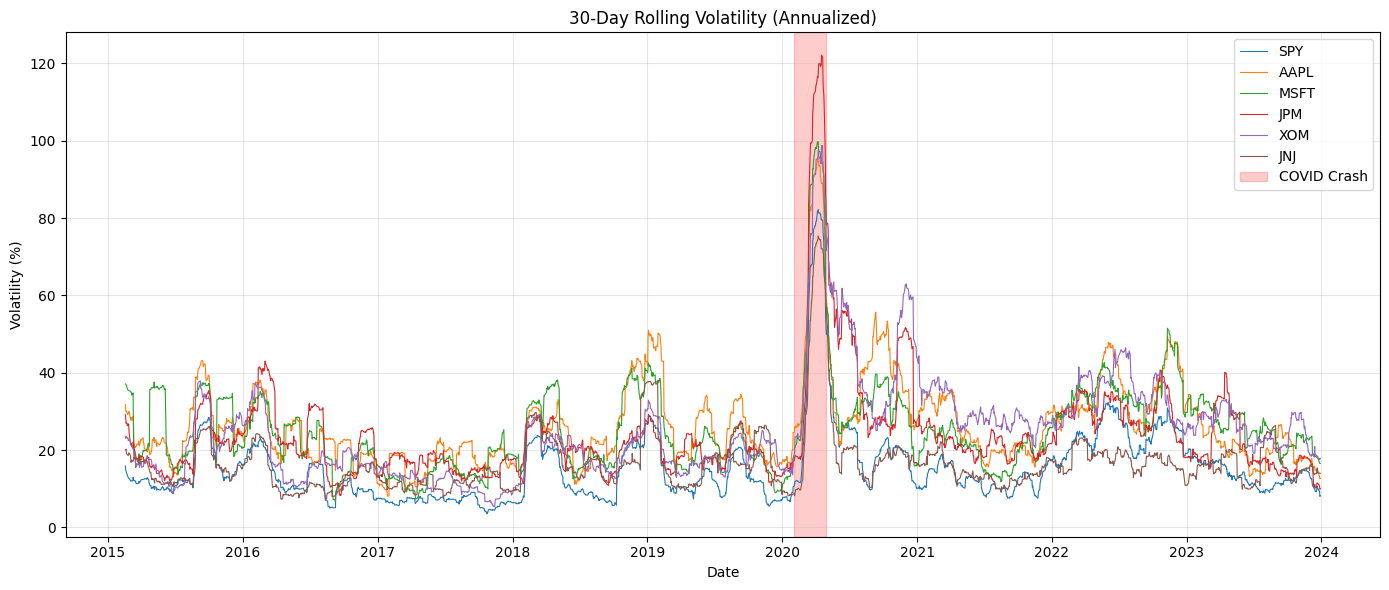

In [ ]:
# Rolling Volatility Over Time
fig, ax = plt.subplots(figsize=(14, 6))

for ticker, df in raw_data.items():
    returns = df['Close'].pct_change()
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252) * 100
    ax.plot(df.index, rolling_vol, label=ticker, linewidth=0.8)

ax.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-30'), 
           alpha=0.2, color='red', label='COVID Crash')
ax.set_title('30-Day Rolling Volatility (Annualized)')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility (%)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rolling_volatility.png', dpi=100)
plt.show()

In [ ]:
# Technical Indicators Function
def add_technical_indicators(df):
    df = df.copy()
    
    # Returns
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Momentum
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    macd = MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()
    
    # Trend
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
    
    # Volatility
    bb = BollingerBands(df['Close'], window=20, window_dev=2)
    df['BB_Width'] = bb.bollinger_wband()
    df['BB_Percent'] = bb.bollinger_pband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    
    # Volume
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    
    # Distance to MAs
    df['Dist_SMA20'] = (df['Close'] - df['SMA_20']) / df['SMA_20']
    df['Dist_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    
    return df.dropna()

print("Technical indicators function defined")

Technical indicators function defined


In [ ]:
# Apply Technical Indicators
processed_data = {}
for ticker, df in raw_data.items():
    processed = add_technical_indicators(df)
    processed_data[ticker] = processed
    print(f"{ticker}: {len(df)} -> {len(processed)} rows ({len(processed.columns)} features)")

print(f"\nNew features: {list(set(processed_data['SPY'].columns) - set(raw_data['SPY'].columns))}")

SPY: 2264 -> 2215 rows (19 features)
AAPL: 2264 -> 2215 rows (19 features)
MSFT: 2264 -> 2215 rows (19 features)
JPM: 2264 -> 2215 rows (19 features)
XOM: 2264 -> 2215 rows (19 features)
JNJ: 2264 -> 2215 rows (19 features)

New features: ['BB_Width', 'BB_Percent', 'RSI', 'OBV', 'SMA_20', 'MACD', 'MACD_Diff', 'Dist_SMA20', 'Dist_SMA50', 'Log_Returns', 'Returns', 'ATR', 'MACD_Signal', 'SMA_50']


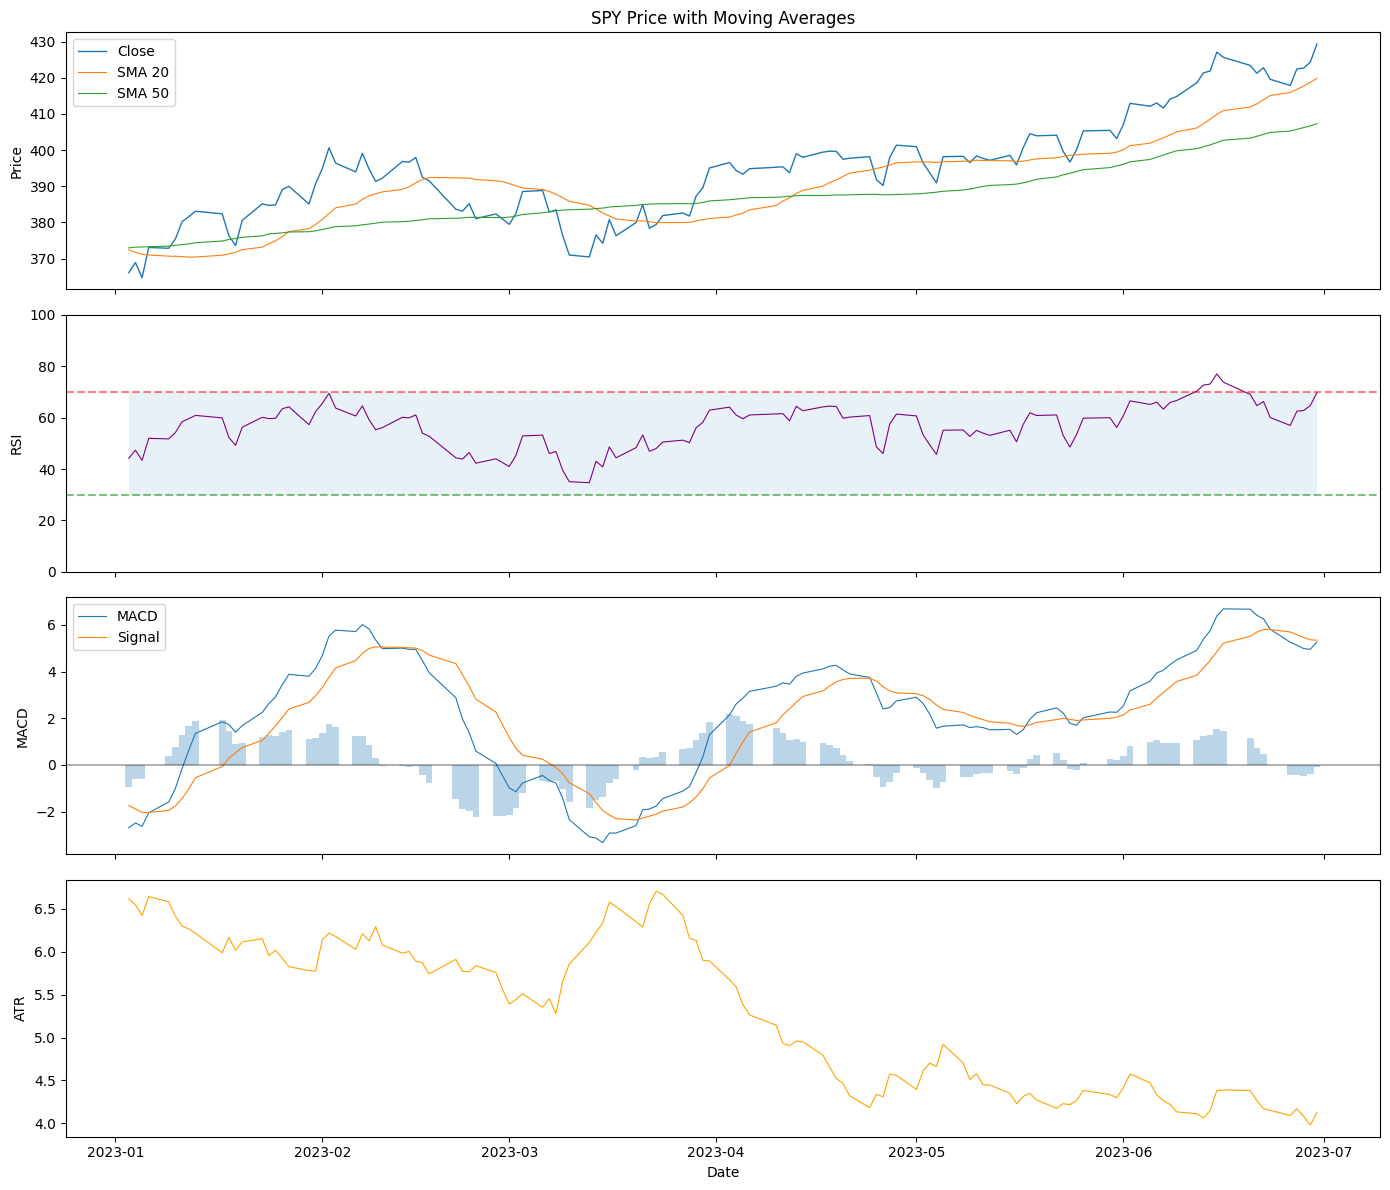

In [ ]:
# Visualize SPY with Indicators
spy = processed_data['SPY'].copy()
sample = spy['2023-01-01':'2023-06-30']

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Price with SMAs
axes[0].plot(sample.index, sample['Close'], label='Close', linewidth=1)
axes[0].plot(sample.index, sample['SMA_20'], label='SMA 20', linewidth=0.8)
axes[0].plot(sample.index, sample['SMA_50'], label='SMA 50', linewidth=0.8)
axes[0].set_ylabel('Price')
axes[0].legend(loc='upper left')
axes[0].set_title('SPY Price with Moving Averages')

# RSI
axes[1].plot(sample.index, sample['RSI'], color='purple', linewidth=0.8)
axes[1].axhline(70, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(30, color='green', linestyle='--', alpha=0.5)
axes[1].fill_between(sample.index, 30, 70, alpha=0.1)
axes[1].set_ylabel('RSI')
axes[1].set_ylim(0, 100)

# MACD
axes[2].plot(sample.index, sample['MACD'], label='MACD', linewidth=0.8)
axes[2].plot(sample.index, sample['MACD_Signal'], label='Signal', linewidth=0.8)
axes[2].bar(sample.index, sample['MACD_Diff'], alpha=0.3, width=1)
axes[2].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[2].set_ylabel('MACD')
axes[2].legend(loc='upper left')

# ATR
axes[3].plot(sample.index, sample['ATR'], color='orange', linewidth=0.8)
axes[3].set_ylabel('ATR')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.savefig('spy_indicators.png', dpi=100)
plt.show()

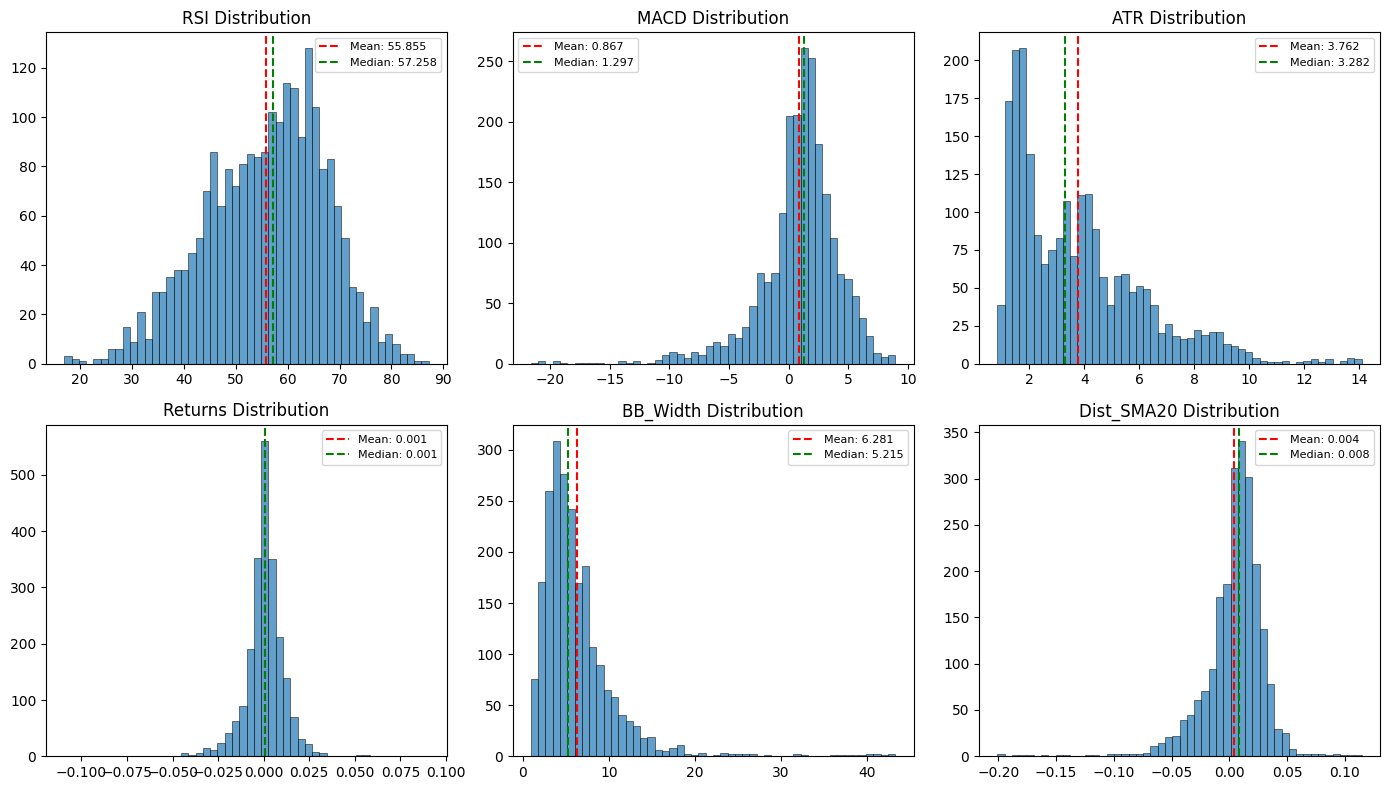

In [ ]:
# Feature Distributions
spy = processed_data['SPY']
features = ['RSI', 'MACD', 'ATR', 'Returns', 'BB_Width', 'Dist_SMA20']

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, feature in enumerate(features):
    data = spy[feature].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.3f}')
    ax.axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.3f}')
    ax.set_title(f'{feature} Distribution')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=100)
plt.show()

In [ ]:
# Outlier Detection
print("Extreme outliers (>5 stddev from mean):\n")

for ticker, df in processed_data.items():
    returns = df['Returns']
    threshold = 5 * returns.std()
    outliers = returns[np.abs(returns - returns.mean()) > threshold]
    
    if len(outliers) > 0:
        print(f"{ticker}: {len(outliers)} extreme days")
        for date, ret in outliers.head(5).items():
            print(f"    {date.strftime('%Y-%m-%d')}: {ret:.4f} ({ret*100:.1f}%)")

Extreme outliers (>5 stddev from mean):

SPY: 8 extreme days
    2020-03-09: -0.0781 (-7.8%)
    2020-03-12: -0.0957 (-9.6%)
    2020-03-13: 0.0855 (8.5%)
    2020-03-16: -0.1094 (-10.9%)
    2020-03-24: 0.0906 (9.1%)
AAPL: 7 extreme days
    2019-01-03: -0.0996 (-10.0%)
    2020-03-02: 0.0931 (9.3%)
    2020-03-12: -0.0988 (-9.9%)
    2020-03-13: 0.1198 (12.0%)
    2020-03-16: -0.1286 (-12.9%)
MSFT: 6 extreme days
    2015-04-24: 0.1045 (10.5%)
    2015-10-23: 0.1008 (10.1%)
    2020-03-12: -0.0948 (-9.5%)
    2020-03-13: 0.1422 (14.2%)
    2020-03-16: -0.1474 (-14.7%)
JPM: 8 extreme days
    2020-03-09: -0.1355 (-13.5%)
    2020-03-13: 0.1801 (18.0%)
    2020-03-16: -0.1496 (-15.0%)
    2020-03-18: -0.1053 (-10.5%)
    2020-03-24: 0.1189 (11.9%)
XOM: 7 extreme days
    2020-03-09: -0.1222 (-12.2%)
    2020-03-12: -0.1143 (-11.4%)
    2020-03-16: -0.0952 (-9.5%)
    2020-03-18: -0.1002 (-10.0%)
    2020-03-24: 0.1269 (12.7%)
JNJ: 12 extreme days
    2018-12-14: -0.1004 (-10.0%)
    20

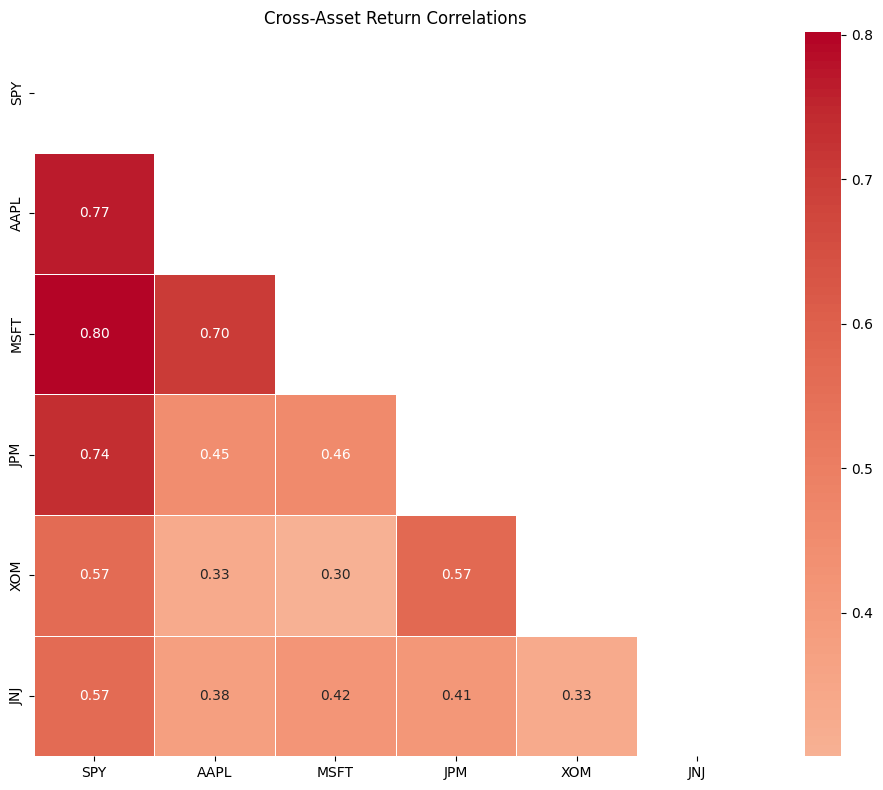


Average pairwise correlation: 0.519
Good diversification


In [ ]:
# Correlation Matrix
returns_df = pd.DataFrame({t: df['Returns'] for t, df in processed_data.items()})
corr = returns_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', linewidths=0.5)
ax.set_title('Cross-Asset Return Correlations')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=100)
plt.show()

avg_corr = corr.values[np.triu_indices_from(corr.values, k=1)].mean()
print(f"\nAverage pairwise correlation: {avg_corr:.3f}")
print("Good diversification" if avg_corr < 0.7 else "High correlation warning")

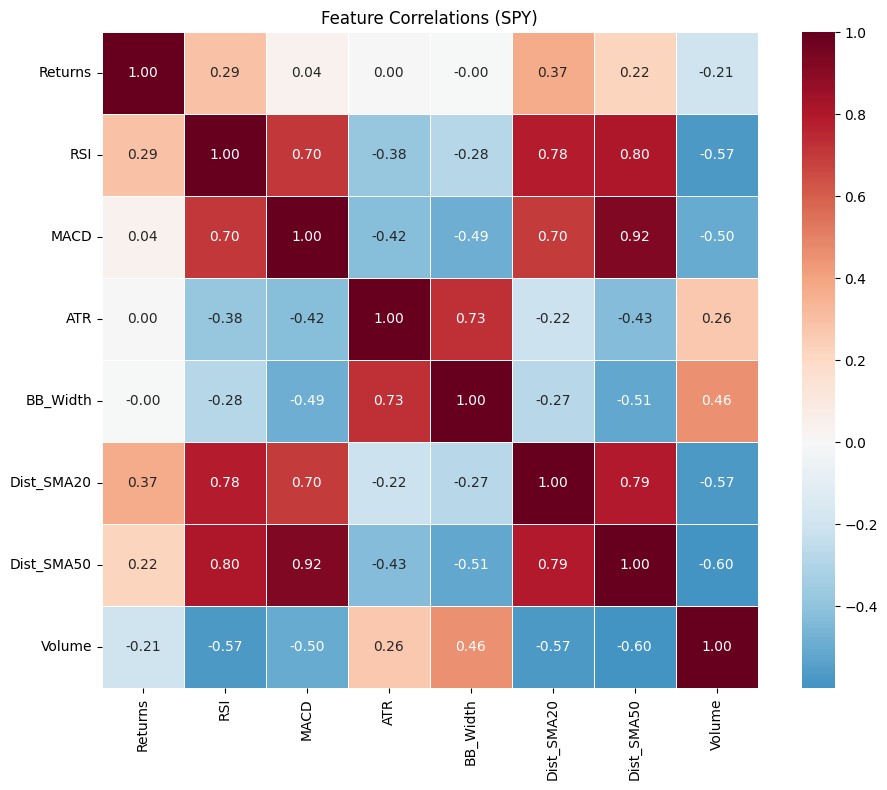

In [ ]:
#Feature Correlation Heatmap (SPY)
spy = processed_data['SPY']
feature_cols = ['Returns', 'RSI', 'MACD', 'ATR', 'BB_Width', 'Dist_SMA20', 'Dist_SMA50', 'Volume']
feature_corr = spy[feature_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(feature_corr, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.2f', linewidths=0.5)
ax.set_title('Feature Correlations (SPY)')
plt.tight_layout()
plt.savefig('feature_correlations.png', dpi=100)
plt.show()

In [ ]:
# Winsorization (Cap Extreme Values)
def winsorize_features(df, lower=0.01, upper=0.99):
    df_clean = df.copy()
    features_to_cap = ['Returns', 'Log_Returns', 'MACD', 'MACD_Diff', 'Dist_SMA20', 'Dist_SMA50']
    for col in features_to_cap:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].clip(
                lower=df_clean[col].quantile(lower),
                upper=df_clean[col].quantile(upper)
            )
    return df_clean

cleaned_data = {}
for ticker, df in processed_data.items():
    cleaned = winsorize_features(df)
    cleaned_data[ticker] = cleaned
    print(f"{ticker}: Returns capped to [{cleaned['Returns'].min():.4f}, {cleaned['Returns'].max():.4f}]")

SPY: Returns capped to [-0.0332, 0.0270]
AAPL: Returns capped to [-0.0490, 0.0490]
MSFT: Returns capped to [-0.0435, 0.0509]
JPM: Returns capped to [-0.0444, 0.0469]
XOM: Returns capped to [-0.0481, 0.0481]
JNJ: Returns capped to [-0.0317, 0.0302]


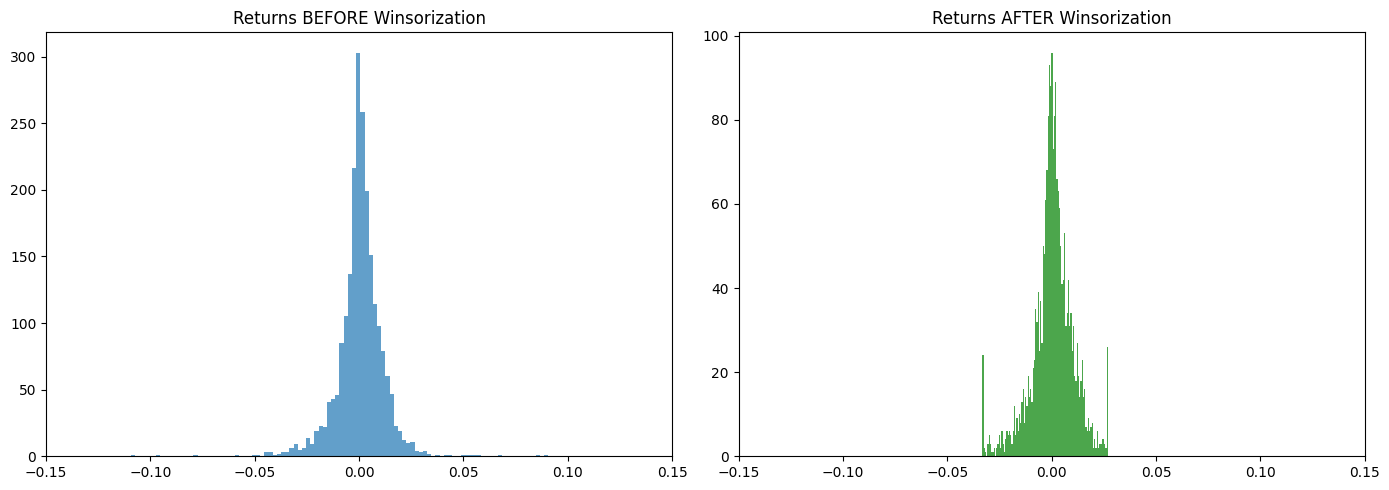

In [ ]:
# Before/After Winsorization Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(processed_data['SPY']['Returns'], bins=100, alpha=0.7)
axes[0].set_title('Returns BEFORE Winsorization')
axes[0].set_xlim(-0.15, 0.15)

axes[1].hist(cleaned_data['SPY']['Returns'], bins=100, alpha=0.7, color='green')
axes[1].set_title('Returns AFTER Winsorization')
axes[1].set_xlim(-0.15, 0.15)

plt.tight_layout()
plt.savefig('winsorization_comparison.png', dpi=100)
plt.show()

In [ ]:
# Temporal Split Definition
def create_temporal_splits(df, train_end='2019-12-31', val_end='2020-12-31'):
    """Train: 2015-2019, Val: 2020 (COVID), Test: 2021-2024"""
    return {
        'train': df[:train_end],
        'val': df[train_end:val_end],
        'test': df[val_end:]
    }

spy_splits = create_temporal_splits(cleaned_data['SPY'])
print("Temporal Split Sizes:")
for name, split in spy_splits.items():
    pct = len(split) / len(cleaned_data['SPY']) * 100
    print(f"  {name}: {len(split)} days ({pct:.1f}%)")

Temporal Split Sizes:
  train: 1209 days (54.6%)
  val: 254 days (11.5%)
  test: 754 days (34.0%)


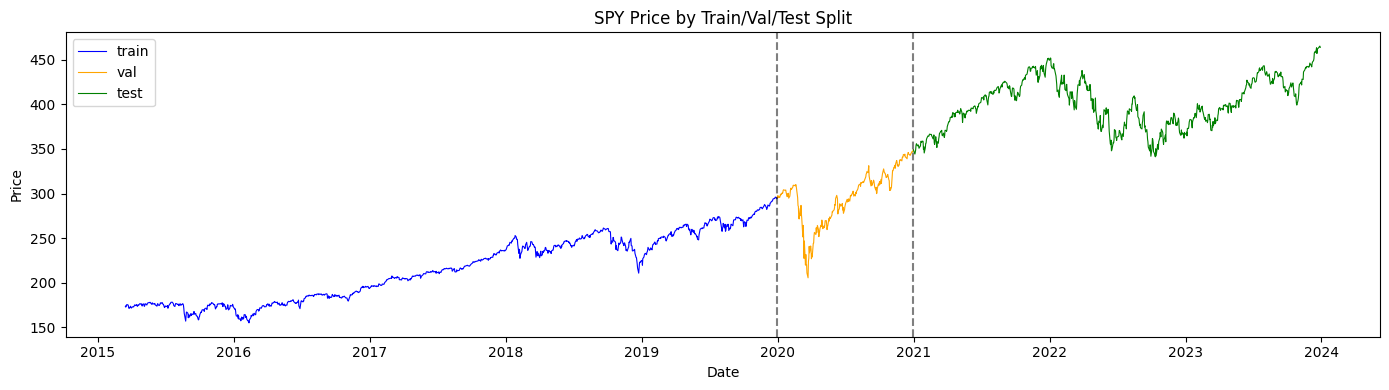

In [ ]:
# Visualize Temporal Splits
fig, ax = plt.subplots(figsize=(14, 4))

colors = {'train': 'blue', 'val': 'orange', 'test': 'green'}
for split_name, split_df in spy_splits.items():
    ax.plot(split_df.index, split_df['Close'], color=colors[split_name], 
            label=split_name, linewidth=0.8)

ax.axvline(pd.Timestamp('2019-12-31'), color='black', linestyle='--', alpha=0.5)
ax.axvline(pd.Timestamp('2020-12-31'), color='black', linestyle='--', alpha=0.5)
ax.set_title('SPY Price by Train/Val/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
plt.tight_layout()
plt.savefig('temporal_splits.png', dpi=100)
plt.show()

In [ ]:
# Split Statistics Comparison
print("Return Statistics by Split:\n")

stats = []
for split_name, split_df in spy_splits.items():
    ret = split_df['Returns']
    stats.append({
        'Split': split_name,
        'Mean': f"{ret.mean()*100:.3f}%",
        'Std': f"{ret.std()*100:.3f}%",
        'Min': f"{ret.min()*100:.2f}%",
        'Max': f"{ret.max()*100:.2f}%",
        'Sharpe': f"{(ret.mean()/ret.std())*np.sqrt(252):.2f}"
    })

print(pd.DataFrame(stats).to_string(index=False))

Return Statistics by Split:

Split   Mean    Std    Min   Max Sharpe
train 0.047% 0.821% -3.32% 2.70%   0.91
  val 0.082% 1.434% -3.32% 2.70%   0.91
 test 0.042% 1.076% -3.32% 2.70%   0.63


In [ ]:
# Fit Scalers on Training Data Only
features_to_scale = ['RSI', 'MACD', 'ATR', 'OBV', 'BB_Width', 'Dist_SMA20', 'Dist_SMA50', 'Volume']
scaled_data = {}
scalers = {}

for ticker in cleaned_data.keys():
    splits = create_temporal_splits(cleaned_data[ticker])
    scaler = StandardScaler()
    
    # Fit on train ONLY
    train_scaled = scaler.fit_transform(splits['train'][features_to_scale])
    val_scaled = scaler.transform(splits['val'][features_to_scale])
    test_scaled = scaler.transform(splits['test'][features_to_scale])
    
    for split_name, scaled_array in zip(['train', 'val', 'test'], [train_scaled, val_scaled, test_scaled]):
        split_df = splits[split_name].copy()
        scaled_df = pd.DataFrame(
            scaled_array, 
            columns=[f"{col}_norm" for col in features_to_scale],
            index=split_df.index
        )
        splits[split_name] = pd.concat([split_df, scaled_df], axis=1)
    
    scaled_data[ticker] = splits
    scalers[ticker] = scaler

print(f"Scaled {len(scaled_data)} assets")
print(f"Features per asset: {len(scaled_data['SPY']['train'].columns)}")

Scaled 6 assets
Features per asset: 27


In [ ]:
# Verify Scaling (No Data Leakage)
print("Scaled feature statistics across splits (SPY RSI_norm):\n")

for split in ['train', 'val', 'test']:
    data = scaled_data['SPY'][split]['RSI_norm']
    print(f"{split}: mean={data.mean():.4f}, std={data.std():.4f}")

print("\nTrain should have mean~0, std~1. Val/Test may differ (no leakage).")

Scaled feature statistics across splits (SPY RSI_norm):

train: mean=-0.0000, std=1.0004
val: mean=0.0246, std=1.0084
test: mean=-0.1945, std=0.9949

Train should have mean~0, std~1. Val/Test may differ (no leakage).


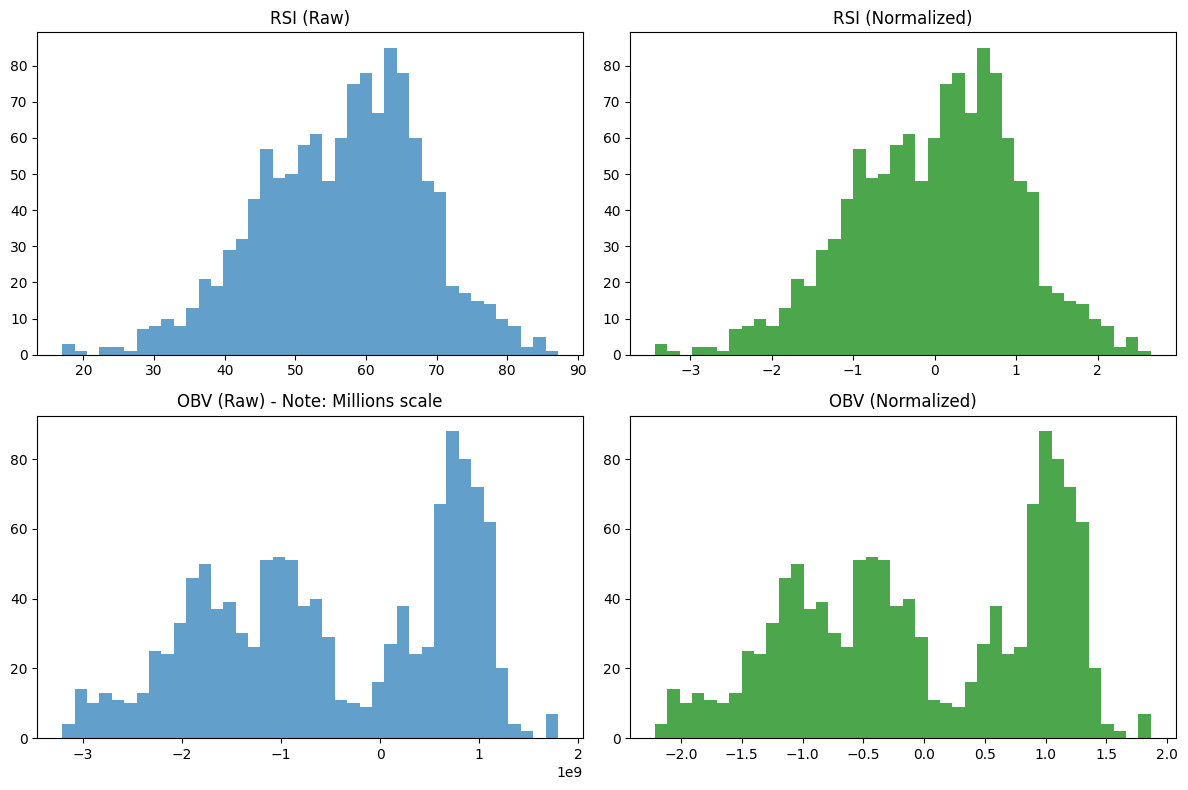

In [ ]:
# Scaled vs Raw Feature Comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

spy_train = scaled_data['SPY']['train']

axes[0, 0].hist(spy_train['RSI'], bins=40, alpha=0.7)
axes[0, 0].set_title('RSI (Raw)')

axes[0, 1].hist(spy_train['RSI_norm'], bins=40, alpha=0.7, color='green')
axes[0, 1].set_title('RSI (Normalized)')

axes[1, 0].hist(spy_train['OBV'], bins=40, alpha=0.7)
axes[1, 0].set_title('OBV (Raw) - Note: Millions scale')

axes[1, 1].hist(spy_train['OBV_norm'], bins=40, alpha=0.7, color='green')
axes[1, 1].set_title('OBV (Normalized)')

plt.tight_layout()
plt.savefig('scaling_comparison.png', dpi=100)
plt.show()

In [ ]:
# Save Processed Data
import os
import pickle
import json

os.makedirs('data/processed', exist_ok=True)

file_count = 0
for ticker, splits in scaled_data.items():
    for split_name, df in splits.items():
        filename = f'data/processed/{ticker}_{split_name}.parquet'
        df.to_parquet(filename)
        file_count += 1

with open('data/processed/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

print(f"Saved {file_count} parquet files + scalers.pkl")

Saved 18 parquet files + scalers.pkl


In [ ]:
returns_df = pd.DataFrame({t: df['Returns'] for t, df in cleaned_data.items()})
corr = returns_df.corr()
avg_corr = corr.values[np.triu_indices_from(corr.values, k=1)].mean()

report = {
    'universe': list(tickers.keys()),
    'date_range': f'{start_date} to {end_date}',
    'train_size': len(scaled_data['SPY']['train']),
    'val_size': len(scaled_data['SPY']['val']),
    'test_size': len(scaled_data['SPY']['test']),
    'features_total': len(scaled_data['SPY']['train'].columns),
    'features_normalized': len([c for c in scaled_data['SPY']['train'].columns if '_norm' in c]),
    'avg_correlation': round(avg_corr, 3),
    'technical_indicators': ['RSI', 'MACD', 'SMA_20', 'SMA_50', 'ATR', 'OBV', 'BB_Width', 'BB_Percent'],
    'scaling_method': 'StandardScaler (fit on train only)',
    'outlier_treatment': 'Winsorized at 1st/99th percentile'
}

with open('data/processed/data_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print(json.dumps(report, indent=2))

{
  "universe": [
    "SPY",
    "AAPL",
    "MSFT",
    "JPM",
    "XOM",
    "JNJ"
  ],
  "date_range": "2015-01-01 to 2024-01-01",
  "train_size": 1209,
  "val_size": 254,
  "test_size": 754,
  "features_total": 27,
  "features_normalized": 8,
  "avg_correlation": 0.487,
  "technical_indicators": [
    "RSI",
    "MACD",
    "SMA_20",
    "SMA_50",
    "ATR",
    "OBV",
    "BB_Width",
    "BB_Percent"
  ],
  "scaling_method": "StandardScaler (fit on train only)",
  "outlier_treatment": "Winsorized at 1st/99th percentile"
}


In [ ]:
import os

files = os.listdir('data/processed')
print(f"Files saved: {len(files)}")
print(f"Parquet files: {len([f for f in files if f.endswith('.parquet')])}")
print(f"\nExpected: 18 parquet (6 assets x 3 splits) + scalers.pkl + data_report.json")

Files saved: 20
Parquet files: 18

Expected: 18 parquet (6 assets x 3 splits) + scalers.pkl + data_report.json


In [ ]:
summary = []
for ticker in tickers.keys():
    df = cleaned_data[ticker]
    ret = df['Returns']
    summary.append({
        'Ticker': ticker,
        'Days': len(df),
        'Ann. Return': f"{ret.mean() * 252 * 100:.1f}%",
        'Ann. Vol': f"{ret.std() * np.sqrt(252) * 100:.1f}%",
        'Sharpe': f"{(ret.mean() / ret.std()) * np.sqrt(252):.2f}",
        'Max DD': f"{((df['Close'] / df['Close'].cummax()) - 1).min() * 100:.1f}%"
    })

print(pd.DataFrame(summary).to_string(index=False))

Ticker  Days Ann. Return Ann. Vol Sharpe Max DD
   SPY  2215       12.4%    15.8%   0.79 -33.7%
  AAPL  2215       25.3%    26.5%   0.95 -38.5%
  MSFT  2215       29.0%    25.1%   1.16 -37.1%
   JPM  2215       16.8%    24.1%   0.70 -43.6%
   XOM  2215       10.0%    26.2%   0.38 -61.3%
   JNJ  2215        9.3%    15.9%   0.58 -27.4%
